## Analyzing the change in mRNA-protein correlation using different factors

**Input:**               
1. Processed mRNA-protein correlation of studies containing proteomic replicates - ovarian, colon and CCLE 
2. Processed protein-protein correlation of the above studies      

#### Import Packages

In [1]:
import re, os
import numpy as np
import pandas as pd
import seaborn as sns 
from matplotlib import pyplot as plt
plt.style.use(['seaborn-white'])

%matplotlib inline
import common_utils as cu
import graphing_utils as gu
import customized_plots

In [2]:
get_data_path = lambda folders, fname: os.path.normpath(os.environ['DATA_PATH']+'/'+'/'.join(folders) +'/'+ fname)
get_local_data_path = lambda folders, fname: os.path.normpath('../local_data/'+'/'+'/'.join(folders) +'/'+ fname)

file_proteomic_replicate_correlations = get_local_data_path(['processed', 'correlation_replicates'], 
                                                            'proteomic_reproducibility.csv')
file_mRNA_protein_correlations = get_local_data_path(['results'], 'TableS1.xlsx')
file_protein_complexes = get_data_path(['protein_properties', 'CORUM'], 'allComplexes.txt')

#### Load Data

In [3]:
replicate_correlations = pd.read_csv(file_proteomic_replicate_correlations, index_col=0)
replicate_correlations[:2]

,Ovarian (JHU-PNNL),Colon (TMT-LF),CCLE (R1-R3)
A1BG,0.739736,0.256359,NaN
A2M,0.811584,0.227659,0.541796


In [4]:
replicates_cor_ccle = replicate_correlations['CCLE (R1-R3)'].copy(deep=True).dropna()
replicates_cor_ov = replicate_correlations['Ovarian (JHU-PNNL)'].copy(deep=True).dropna()
replicates_cor_colon = replicate_correlations['Colon (TMT-LF)'].copy(deep=True).dropna()

In [5]:
mRNA_protein_correlations =  pd.read_excel(file_mRNA_protein_correlations, sheet_name='A. mRNA-protein correlation', 
                                           index_col=0)
mRNA_protein_correlations[:2]

,CRC (2014),BrCa (2016),Ovarian,Colon,ccRCC,EC,LUAD,BrCa (2020),HNSCC,GBM,NCI60,CCLE,GTEx
Gene symbol,,,,,,,,,,,,,
A1BG,0.123133,-0.093805,-0.078889,NaN,0.035573,0.324974,-0.119663,0.077242,0.065872,-0.192863,NaN,NaN,0.154523
A1CF,NaN,NaN,NaN,0.673548,0.908613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.188605


In [6]:
mRNA_protein_cor_ccle =  mRNA_protein_correlations['CCLE'].copy(deep=True).dropna()
mRNA_protein_cor_ov =  mRNA_protein_correlations['Ovarian'].copy(deep=True).dropna()
mRNA_protein_cor_colon =  mRNA_protein_correlations['Colon'].copy(deep=True).dropna()

### 1.  Distribution of mRNA-protein correlation for studies with proteomic replicates

In [7]:
args = [gu.additional_plot_parameters(xlab="Colon mRNA-protein correlation", ylab="Density"),
        gu.additional_plot_parameters(xlab="OV mRNA-protein correlation", ylab=None),
        gu.additional_plot_parameters(xlab="CCLE mRNA-protein correlation", ylab=None)]

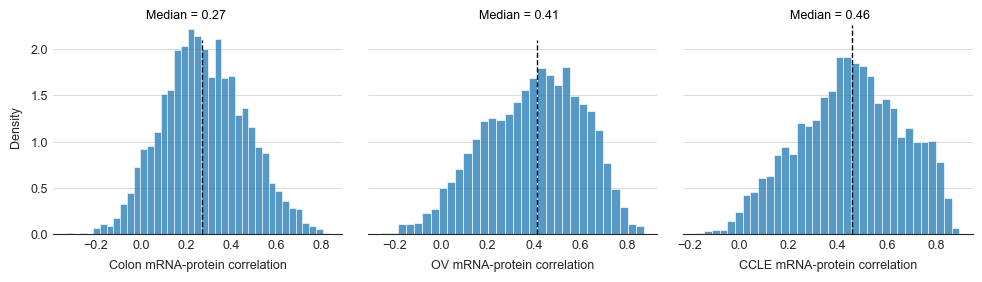

In [8]:
figure, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
customized_plots.draw_histogram(axes[0], mRNA_protein_cor_colon, args[0])  
customized_plots.draw_histogram(axes[1], mRNA_protein_cor_ov, args[1])
customized_plots.draw_histogram(axes[2], mRNA_protein_cor_ccle, args[2], ymax = 0.97)  
figure.tight_layout(pad=1.5)

### 2. Identify the variation in mRNA-protein correlation for stratified protein reproducibility measurements

Regress the mRNA-protein correlation with protein-protein correlation to understand the variance in mRNA-protein correlation explained by protein-protein correlation

In [9]:
import statsmodels.api as sm

# regressing y on x 
def ols_fit(x, y, match_subsets=True):
    x_subset, y_subset = cu.get_matched_index(x, y) 
    est = sm.OLS(y_subset, sm.add_constant(x_subset.astype(float))).fit()
    return est

In [10]:
r2_protein_reproducibility = {}

r2_protein_reproducibility['OV'] = round(ols_fit(x=replicates_cor_ov, y=mRNA_protein_cor_ov).rsquared_adj *100, 2)
r2_protein_reproducibility['CCLE'] = round(ols_fit(x=replicates_cor_ccle, y=mRNA_protein_cor_ccle).rsquared_adj * 100, 2)
r2_protein_reproducibility['Colon'] = round(ols_fit(x=replicates_cor_colon,y=mRNA_protein_cor_colon).rsquared_adj * 100, 2)

C:\Users\swath\Anaconda3\envs\thesis\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<div class="alert alert-block alert-warning">
    How does mRNA-protein correlation vary with respect to protein-protein reproducibility?</div>

In [11]:
ylab = 'mRNA-Protein correlation'
palette = [gu.get_color('light-orange')]
args = [gu.additional_plot_parameters(xlab="Protein Replicate (TMT-LF) Correlation Deciles", ylab=ylab, 
                                      title = 'Colon Adenocarcinoma', palette=palette, show_legend=False, 
                                      r2=r2_protein_reproducibility['Colon']),
        gu.additional_plot_parameters(xlab="Protein Replicate (JHU-PNNL) Correlation Deciles", ylab=ylab, 
                                      title = 'Ovarian Cancer', palette=palette, 
                                      r2=r2_protein_reproducibility['OV']),
        gu.additional_plot_parameters(xlab="Protein Replicate (R1-R3) Correlation Deciles", ylab=ylab, 
                                      title = 'CCLE', palette=palette, show_legend=False, 
                                      r2=r2_protein_reproducibility['CCLE'])]

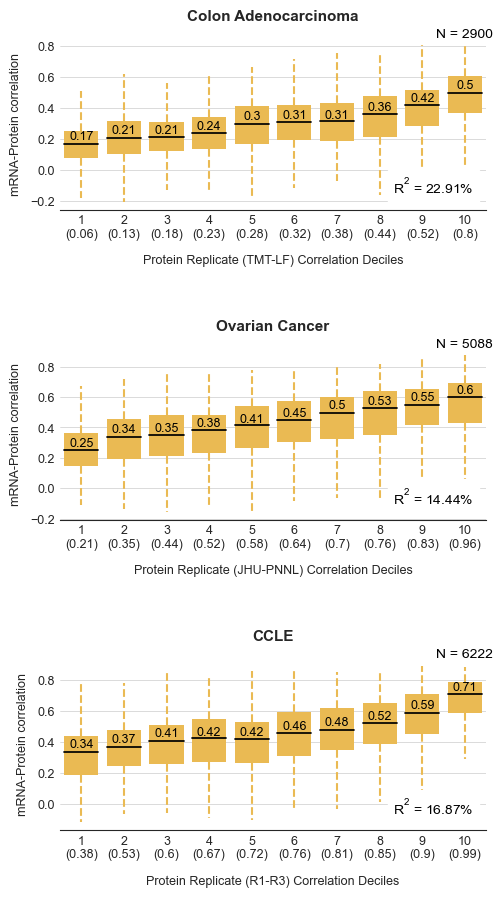

In [12]:
with plt.rc_context({'axes.linewidth': 0.8}):
    figure, ax = plt.subplots(3, 1, figsize=(5.5,10.5))
    customized_plots.draw_boxplot(ax[0], replicates_cor_colon, mRNA_protein_cor_colon, args[0])
    customized_plots.draw_boxplot(ax[1], replicates_cor_ov, mRNA_protein_cor_ov, args[1])
    customized_plots.draw_boxplot(ax[2], replicates_cor_ccle, mRNA_protein_cor_ccle, args[2])
    plt.subplots_adjust(hspace=0.8)
#     figure.savefig('../figures/Figure2.svg', bbox_inches='tight', dpi=300)

### 3. Compare the variation in mRNA-protein correlation using biological factor and technical factor 

<div class="alert alert-block alert-warning">
How does a previously known biological factor (protein complex membership) compare to a technical factor (protein measurement reproducibility) in explaining the variation of mRNA-protein correlation ?</div>

In [13]:
protein_complexes = pd.read_csv(file_protein_complexes, sep="\t", index_col=0)
protein_complexes = protein_complexes[protein_complexes["Organism"] == "Human"][["subunits(Gene name)"]]
protein_complex_members = pd.unique(protein_complexes["subunits(Gene name)"].str.split(";", expand=True).stack()).tolist()
print("Dimensions: ", len(protein_complex_members))

Dimensions:  3664


In [14]:
def get_protein_complex_membership(series): 
    return pd.Series([True if x in protein_complex_members else False for x in series.index], index=series.index)
    
ov_reproducibility_complex_membership = pd.concat([replicates_cor_ov, get_protein_complex_membership(replicates_cor_ov)], 
                                                  axis=1)
ccle_reproducibility_complex_membership = pd.concat([replicates_cor_ccle, 
                                                     get_protein_complex_membership(replicates_cor_ccle)], axis=1)
colon_reproducibility_complex_membership = pd.concat([replicates_cor_colon, 
                                                      get_protein_complex_membership(replicates_cor_colon)], axis=1)
ov_reproducibility_complex_membership.columns = ccle_reproducibility_complex_membership.columns = \
        colon_reproducibility_complex_membership.columns = ['Protein reproducibility', 'Protein complex subunit']

In [15]:
r2_complex_info = {}
r2_combined = {}
r2_protein_reproducibility = {}

print("Regressing mRNA-protein correlation using complex membership information")
r2_protein_reproducibility['Ovarian'] = round(ols_fit(x=ov_reproducibility_complex_membership['Protein reproducibility'],
                                                      y=mRNA_protein_cor_ov).rsquared_adj *100, 2)
r2_protein_reproducibility['CCLE'] = round(ols_fit(x=ccle_reproducibility_complex_membership['Protein reproducibility'], 
                                                   y=mRNA_protein_cor_ccle).rsquared_adj * 100, 2)
r2_protein_reproducibility['Colon'] = round(ols_fit(x=colon_reproducibility_complex_membership['Protein reproducibility'],
                                                    y=mRNA_protein_cor_colon).rsquared_adj * 100, 2)

print("Regressing mRNA-protein correlation using complex membership information")
r2_complex_info['Ovarian'] = round(ols_fit(x=ov_reproducibility_complex_membership['Protein complex subunit'], 
                                      y=mRNA_protein_cor_ov).rsquared_adj* 100, 2)
r2_complex_info['CCLE'] = round(ols_fit(x=ccle_reproducibility_complex_membership['Protein complex subunit'], 
                                        y=mRNA_protein_cor_ccle).rsquared_adj* 100, 2)
r2_complex_info['Colon'] = round(ols_fit(x=colon_reproducibility_complex_membership['Protein complex subunit'],  
                                         y=mRNA_protein_cor_colon).rsquared_adj* 100, 2)

print("Regressing mRNA-protein correlation combining both factors")
r2_combined['Ovarian'] = round(ols_fit(x=ov_reproducibility_complex_membership, 
                                  y=mRNA_protein_cor_ov).rsquared_adj * 100, 2)
r2_combined['CCLE'] = round(ols_fit(x=ccle_reproducibility_complex_membership, 
                                    y=mRNA_protein_cor_ccle).rsquared_adj * 100, 2)
r2_combined['Colon'] = round(ols_fit(x=colon_reproducibility_complex_membership,
                                     y=mRNA_protein_cor_colon).rsquared_adj * 100, 2)

Regressing mRNA-protein correlation using complex membership information
Regressing mRNA-protein correlation using complex membership information
Regressing mRNA-protein correlation combining both factors


C:\Users\swath\Anaconda3\envs\thesis\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [16]:
# Creating a dataframe from the multiple dictionaries providing the factors, 
# repeating the factors based on the number of studies, and the dictionaries
proteins_count = {'Ovarian': len(ov_reproducibility_complex_membership.index[ov_reproducibility_complex_membership.index.isin(mRNA_protein_cor_ov.index)]), 
                 'Colon': len(colon_reproducibility_complex_membership.index[colon_reproducibility_complex_membership.index.isin(mRNA_protein_cor_colon.index)]), 
                 'CCLE': len(ccle_reproducibility_complex_membership.index[ccle_reproducibility_complex_membership.index.isin(mRNA_protein_cor_ccle.index)])}
r2_replicates = cu.dataframe_from_dict(['Protein\ncomplex\nmembership', 'Protein\nreproducibility', 'Both', 'Proteins Count'],                                        
                                        r2_complex_info, r2_protein_reproducibility, r2_combined, proteins_count,
                                       repeat_factor=len(r2_complex_info))

Factor,Data,Both,Protein complex membership,Protein reproducibility,Proteins Count
0,CCLE,22.75,8.35,16.87,6222
1,Colon,26.46,6.62,22.91,2900
2,Ovarian,16.90,3.42,14.44,5088


In [17]:
dot_plot_args = gu.additional_plot_parameters(xlab="R-squared (%)", ylab=None, yaxis_grid=False, xaxis_grid=True,
                                              show_legend=True, anchor_legend_at=(-0.28, 1),
                                              palette=[gu.get_color(x) for x in ['orange', 'green', 'grey']])
palette = [gu.get_color(x) for x in ['denim-blue', 'dark-sky-blue', 'light-blue']]
for arg in args:
    arg.palette = palette

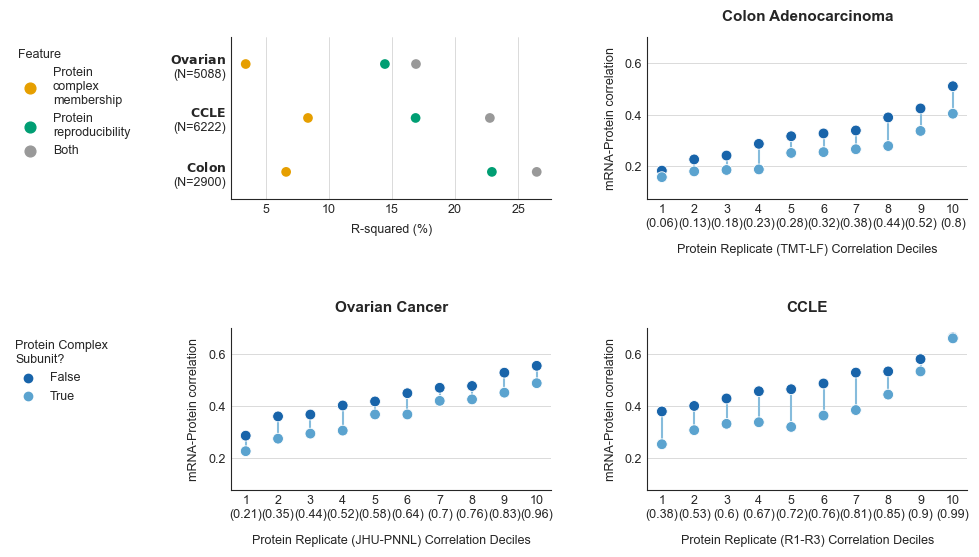

In [18]:
get_order = lambda df: df.groupby(by=['Data']).sum().sort_values('R-squared').index.values
with plt.rc_context({'axes.linewidth': 0.8, 'axes.spines.left': True}):
    figure, ax = plt.subplots(2, 2, figsize=(9.5,6))
    customized_plots.draw_dotplot(ax=ax[0,0], x='R-squared', y='Data', data=r2_replicates, hue='Factor', 
                                  order=get_order(r2_replicates), args=dot_plot_args)
    customized_plots.draw_ranged_dotplot(ax[0, 1], replicates_cor_colon, mRNA_protein_cor_colon, 
                                         protein_complex_members, args[0])
    customized_plots.draw_ranged_dotplot(ax[1, 0], replicates_cor_ov, mRNA_protein_cor_ov, 
                                         protein_complex_members, args[1])
    customized_plots.draw_ranged_dotplot(ax[1, 1], replicates_cor_ccle, mRNA_protein_cor_ccle, 
                                         protein_complex_members, args[2])
    plt.subplots_adjust(hspace=0.8, wspace=0.3)
#     figure.savefig('../figures/S1.svg', bbox_inches='tight', dpi=300)

#### 4. Performing Likelihood ratio test to ensure the models with individual factors are different from the combined model

In [19]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

In [20]:
def lrtest(llmin, llmax):
    lr = 2 * (llmax - llmin)
    p = stats.chisqprob(lr, 1) # llmax has 1 dof more than llmin
    return lr, p

In [21]:
all_replicate_studies = [replicates_cor_ov, replicates_cor_ccle, replicates_cor_colon]
all_mRNA_protein_cor_studies = [mRNA_protein_cor_ov, mRNA_protein_cor_ccle, mRNA_protein_cor_colon]

In [22]:
llf_complex_info = {}
llf_combined = {}
llf_protein_reproducibility = {}

print("Regressing mRNA-protein correlation using complex membership information")
llf_protein_reproducibility['Ovarian'] = ols_fit(x=ov_reproducibility_complex_membership['Protein reproducibility'],
                                                      y=mRNA_protein_cor_ov).llf
llf_protein_reproducibility['CCLE'] = ols_fit(x=ccle_reproducibility_complex_membership['Protein reproducibility'], 
                                                   y=mRNA_protein_cor_ccle).llf
llf_protein_reproducibility['Colon'] = ols_fit(x=colon_reproducibility_complex_membership['Protein reproducibility'],
                                                    y=mRNA_protein_cor_colon).llf

print("Regressing mRNA-protein correlation using complex membership information")
llf_complex_info['Ovarian'] = ols_fit(x=ov_reproducibility_complex_membership['Protein complex subunit'], 
                                      y=mRNA_protein_cor_ov).llf
llf_complex_info['CCLE'] = ols_fit(x=ccle_reproducibility_complex_membership['Protein complex subunit'], 
                                        y=mRNA_protein_cor_ccle).llf
llf_complex_info['Colon'] = ols_fit(x=colon_reproducibility_complex_membership['Protein complex subunit'],  
                                         y=mRNA_protein_cor_colon).llf

print("Regressing mRNA-protein correlation combining both factors")
llf_combined['Ovarian'] = ols_fit(x=ov_reproducibility_complex_membership, 
                                  y=mRNA_protein_cor_ov).llf
llf_combined['CCLE'] = ols_fit(x=ccle_reproducibility_complex_membership, 
                                    y=mRNA_protein_cor_ccle).llf
llf_combined['Colon'] = ols_fit(x=colon_reproducibility_complex_membership,
                                     y=mRNA_protein_cor_colon).llf

Regressing mRNA-protein correlation using complex membership information
Regressing mRNA-protein correlation using complex membership information
Regressing mRNA-protein correlation combining both factors


C:\Users\swath\Anaconda3\envs\thesis\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [23]:
print('Ovarian: \n')
lr, p = lrtest(llf_protein_reproducibility['Ovarian'], llf_combined['Ovarian'])
print('Reproducibility v/s combined model : LR test statistic = {:.2f},  p value = {:.5g}'.format(lr, p))
lr, p = lrtest(llf_complex_info['Ovarian'], llf_combined['Ovarian'])
print('Complex Membership v/s combined model: LR test statistic = {:.2f},  p value = {:.5g}\n'.format(lr, p))

print('Colon: \n')
lr, p = lrtest(llf_protein_reproducibility['Colon'], llf_combined['Colon'])
print('Reproducibility v/s combined model : LR test statistic =  {:.2f},  p value = {:.5g}'.format(lr, p))
lr, p = lrtest(llf_complex_info['Colon'], llf_combined['Colon'])
print('Complex Membership v/s combined model : LR test statistic =  {:.2f},  p value = {:.5g}\n'.format(lr, p))

print('CCLE: \n')
lr, p = lrtest(llf_protein_reproducibility['CCLE'], llf_combined['CCLE'])
print('Reproducibility v/s combined model : LR test statistic =  {:.2f},  p value = {:.5g}'.format(lr, p))
lr, p = lrtest(llf_complex_info['CCLE'], llf_combined['CCLE'])
print('Complex Membership v/s combined model : LR test statistic =  {:.2f},  p value = {:.5g}\n'.format(lr, p))

Ovarian: 

Reproducibility v/s combined model : LR test statistic = 149.57,  p value = 2.1517e-34
Complex Membership v/s combined model: LR test statistic = 766.04,  p value = 1.3027e-168

Colon: 

Reproducibility v/s combined model : LR test statistic =  137.84,  p value = 7.9109e-32
Complex Membership v/s combined model : LR test statistic =  693.84,  p value = 6.5332e-153

CCLE: 

Reproducibility v/s combined model : LR test statistic =  457.07,  p value = 2.0894e-101
Complex Membership v/s combined model : LR test statistic =  1064.18,  p value = 2.0178e-233



<div class="alert alert-block alert-success">
    Based on the above results where p < 0.001, we understand that the combined model is better than the individual model for all the studies considered</div>